## Notebook con pruebas de cara a la simulación. Teniendo en cuenta la cantidad de tramos y posibles combinaciones de potencias, es necesario tener un punto de partida adecuado para la simulación
No tendría sentido probar en bajadas pronunciadas con potencias muy altas, debido a que normalmente se usan para descansar, beber, etc y que al haber curvas, es posible que no puedan desarrollarse esas velocidades
Por otro lado, en las subidas pronunciadas, la lógica hace pensar que si los watios no son 'gastados' contra el viento, sea lógico aumentar el nivel de esfuerzo, puesto que la transformación de esfuerzo en velocidad es lineal
Hay que recordar que el objetivo de esta simulación es proveer a un ciclista de un plan de competición que pueda ejecutar. Por lo tanto hay que controlar que las potencias resultantes son 'fisiologicamente' admisibles

### Importamos librerías

In [1]:
import os
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')
import numpy as np
import plotly.graph_objs as go
import ipywidgets as widgets
import plotly as py
import math as mt
py.offline.init_notebook_mode(connected=True)

### Cargamos los datos

In [2]:
path = '../Entrenamientos/Procesado_Tramos.xlsx'

In [3]:
df = pd.read_excel(path)

In [4]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum
count,1566.000000,1566.000000,1566.000000,1564.000000,1566.000000,1566.000000,1566.000000,1563.000000,1566.000000,1566.000000
mean,88.273946,3193.413155,3237.544700,172.841148,77.945083,604.974227,inf,-0.523086,NaN,43956.065230
std,74.367035,2006.879552,2007.195839,58.752558,163.853506,990.936845,NaN,15.893856,NaN,27597.295988
min,0.000000,0.000000,5.000000,0.000000,-19.000000,0.000000,-5.142857,-30.119336,-inf,63.000000
25%,35.000000,1533.000000,1561.250000,138.296295,6.000000,50.337673,25.886720,-11.651183,-0.673262,20811.460000
50%,71.000000,3030.000000,3163.000000,180.189194,39.000000,328.367595,31.469712,-0.671048,-0.001459,42480.000000
75%,116.000000,4783.000000,4819.000000,215.477559,78.000000,682.200031,37.867565,11.295255,0.582053,65076.261277
max,345.000000,7796.000000,7830.000000,394.699287,2747.000000,10273.070042,inf,29.972648,inf,107610.184614


### Filtramos outliers

In [5]:
df = df[df["viento_aparente"]!=-np.inf]
df = df[df["porc"]!=np.inf]
df["puntos_en_tramo"]= df["tramo_final"]-df["tramo_inicial"]
df = df[df["puntos_en_tramo"]>10]
df = df[df["dist"]>400]

In [6]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,puntos_en_tramo
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000
mean,75.742898,3236.553977,3324.062500,170.397681,155.754261,1197.764171,31.884690,0.206131,-0.013950,45182.282085,87.508523
std,62.024779,2032.023813,2030.134928,61.189771,220.168319,1236.629743,8.927396,12.940261,2.313670,27986.826277,91.780336
min,0.000000,0.000000,65.000000,1.742131,34.000000,400.613923,11.618577,-29.536164,-6.677410,624.000000,23.000000
25%,29.000000,1518.000000,1589.750000,126.828829,60.000000,529.620097,24.830482,-8.474684,-1.760643,21362.893919,37.000000
50%,65.000000,3036.500000,3205.000000,181.767777,86.000000,741.350014,31.938754,0.320381,-0.367563,44029.333291,54.000000
75%,105.000000,4792.000000,4843.500000,221.011141,160.000000,1220.595748,38.095553,8.653271,1.735269,66243.249904,91.000000
max,345.000000,7796.000000,7830.000000,278.991626,2747.000000,10273.070042,69.830249,29.517057,7.137195,107610.184614,796.000000


In [7]:
df.head()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba,puntos_en_tramo
8,8,136,164,73.327512,49,412.000000,30.269388,6.109815,-1.811555,1413.000000,20180225_LEVS_195_90_R_E.gpx,28
13,13,190,222,206.796051,64,454.289186,25.553767,6.258684,1.412053,2271.000000,20180225_LEVS_195_90_R_E.gpx,32
14,14,222,281,127.358925,74,774.757500,37.690905,8.309926,-1.323913,3049.515185,20180225_LEVS_195_90_R_E.gpx,59
15,15,281,394,227.806936,226,1931.242500,30.763155,6.478255,1.227197,4979.000000,20180225_LEVS_195_90_R_E.gpx,113
17,17,414,700,229.792174,594,3826.821790,23.192859,3.383788,2.599847,9105.681852,20180225_LEVS_195_90_R_E.gpx,286


## Análisis Gráfico

Usamos Seaborn

In [8]:
import seaborn as sns

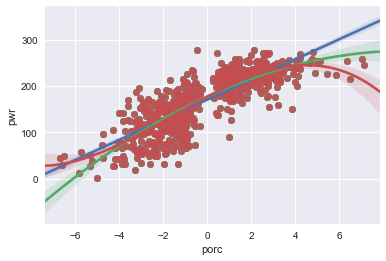

In [9]:
sns.regplot(x = 'porc', y = 'pwr', data=pd.DataFrame(df[['porc','pwr']]),order=1)
sns.regplot(x = 'porc', y = 'pwr', data=pd.DataFrame(df[['porc','pwr']]),order=2)
sns.regplot(x = 'porc', y = 'pwr', data=pd.DataFrame(df[['porc','pwr']]),order=3)
#sns.regplot(x = 'porc', y = 'pwr', data=pd.DataFrame(df[['porc','pwr']]),robust=True)
#robust=True arroja el mismo resultado que le polinomio de grado 1
#Lo que podemos ver en el polinomio de grado 3, es que existen unas asintotas horizontales que corresponderían con las potencias
#mínimas y máximas. En la zona intermedia, la potencia parece crecer de forma lineal con el portentaje

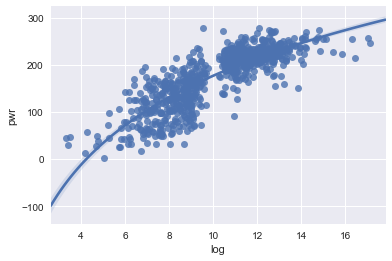

In [10]:
df['log']=df['porc']+10 #para trasladar el eje x y que no de error el log
sns.regplot(x = 'log', y = 'pwr', data=pd.DataFrame(df[['log','pwr']]),logx=True)

Teniendo en cuenta los gráficos anteriores, se podría modelar la potencia en función del porcentaje como una sigmoide

Esto es debido a que en la simulación se va a considerar una potencia mínima y una máxima que no deben ser sobrepasadas

Por otro lado, el crecimiento de la potencia se parece a la función polinómica de grado 3 que hemos visto más arriba

El siguiente gráfico DEBE ser usado para decidir la estrategia de competición. No es lo mismo predecir una etapa montañosa con pendientes constantes altas que una etapa con terreno ondulado de pequeños toboganes

In [11]:
def graph(pot_min, pot_max, ff_1, ff_2):
    #pot_min = 50
    #pot_max = 275
    #ff_1 = 0.8
    #ff_2 = 0.5
    porc = np.arange(-10,10,0.5)

    potencia = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
    potencia_min = pot_min+(pot_max-20-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))
    potencia_max = pot_min+20+(pot_max-pot_min-20)/(1+ff_1*np.e**(ff_2*porc*-1))

    trace0 = go.Scatter(        
            x=porc,
            y=potencia,
            mode='lines',
            name='Potencia_obj')

    trace1 = go.Scatter(        
            x=porc,
            y=potencia_min,
            mode='lines',
            name='Potencia_min')

    trace2 = go.Scatter(        
            x=porc,
            y=potencia_max,
            mode='lines',
            name='Potencia_max')




    layout = go.Layout(title='Sigmoide de potencia')

    data = [trace0, trace1, trace2]

    fig = dict(data=data, layout=layout)

    py.offline.iplot(fig)
    
widgets.interact(graph, pot_min=(40,100,5), pot_max=(250,300,5), ff_1=(0.1,1,0.1), ff_2=(0.1,1,0.1))

interactive(children=(IntSlider(value=70, description='pot_min', min=40, step=5), IntSlider(value=275, descrip…

<function __main__.graph(pot_min, pot_max, ff_1, ff_2)>

Otros análisis de relacionando Potencia con Velocidad y Viento

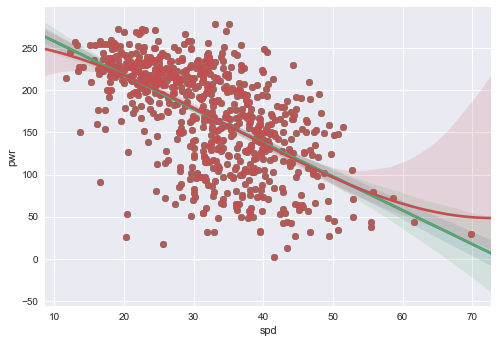

In [34]:
sns.regplot(x = 'spd', y = 'pwr', data=pd.DataFrame(df[['spd','pwr']]),order=1)
sns.regplot(x = 'spd', y = 'pwr', data=pd.DataFrame(df[['spd','pwr']]),order=2)
sns.regplot(x = 'spd', y = 'pwr', data=pd.DataFrame(df[['spd','pwr']]),order=3)

Se ve una relación negativa porque en las bajadas es cuando no se pedalea y la velocidad es mayor

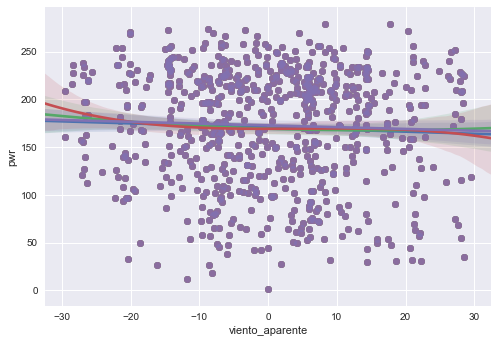

In [35]:
sns.regplot(x = 'viento_aparente', y = 'pwr', data=pd.DataFrame(df[['viento_aparente','pwr']]),order=1)
sns.regplot(x = 'viento_aparente', y = 'pwr', data=pd.DataFrame(df[['viento_aparente','pwr']]),order=2)
sns.regplot(x = 'viento_aparente', y = 'pwr', data=pd.DataFrame(df[['viento_aparente','pwr']]),order=3)
sns.regplot(x = 'viento_aparente', y = 'pwr', data=pd.DataFrame(df[['viento_aparente','pwr']]),robust=True)

No hay una correlación entre el viento con la potencia empleada en entrenamientos. Sin embargo, sabemos que el viento va elevado al cuadrado en la función de la potencia. Deberemos por tanto introducirlo en la inicialización

Con Matplotlib

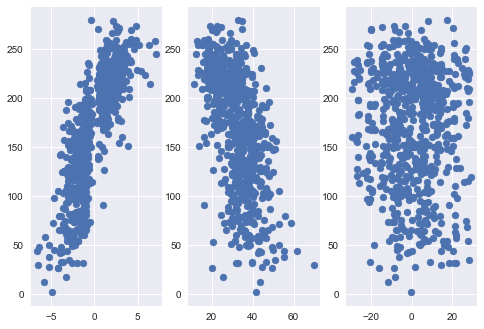

In [36]:
plt.subplot(1,3,1)
plt.scatter(df['porc'],df['pwr'])

plt.subplot(1,3,2)
plt.scatter(df['spd'],df['pwr'])

plt.subplot(1,3,3)
plt.scatter(df['viento_aparente'],df['pwr'])

### Pruebas adicionales en las que creabamos un sencillo modelo lineal para incializar los watios